In [1]:
pwd  #checking current directory

'/workspace/copytodgx'

In [2]:
from numba import cuda
device = cuda.get_current_device()
device.reset()

In [3]:
import numpy as np
import pandas as pd
import glob
#from glob import glob
import random
import matplotlib.pyplot as plt
from pathlib import Path
from PIL import Image
import time
from math import ceil
import os
import cv2
import copy
from tqdm import tqdm
import tensorboard
from itertools import permutations
import seaborn as sns

In [5]:
import warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings("default")
import torch
import torch.nn as nn
import torch.optim as optim
import torch, math
import torch.fft
import torchvision
from torchvision import transforms
import torchvision.transforms as transforms
from torchvision.transforms import ToTensor, Compose, Resize, RandomHorizontalFlip, RandomVerticalFlip,Normalize
#from torchvision.transforms import Compose, ToTensor, Normalize
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.nn.functional as F
from torch import nn, einsum
from einops import rearrange, repeat
from einops.layers.torch import Rearrange
from einops import reduce
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter()
torch.cuda.empty_cache()
out='./results'
if not os.path.exists(out):
    os.makedirs(out)
from torchvision.models import resnet50
import segmentation_models_pytorch as smp

In [6]:
#dataloader_1_random_patch



# Define custom dataset class
class RandomPatchDataset(Dataset):
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.masks = glob.glob(os.path.join(root_dir, 'newimagemask_1024', '*.png'))
        self.images = [mask.replace('.png', '.tiff').replace('newimagemask_1024', 'newimage_1024') for mask in self.masks]

    def __len__(self):
        return len(self.masks)

    def __getitem__(self, idx):
        # Randomly select an index
        random_idx = random.randint(0, len(self.masks) - 1)

        mask_path = self.masks[random_idx]
        image_path = self.images[random_idx]

        mask = Image.open(mask_path).convert('L')  # Ensure grayscale mask
        image = Image.open(image_path).convert('L')  # Load as RGB image

       

        # Define image transformations (normalization)
        transform = transforms.Compose([
            transforms.Resize((1024,1024)),
            transforms.ToTensor()
            
        ])

        image = transform(image)
        mask = transform(mask)

        image_filename = os.path.basename(image_path)
        mask_filename = os.path.basename(mask_path)

        return {'image': image, 'mask': mask.squeeze(0), 'image_filename': image_filename, 'mask_filename': mask_filename}

# Define the root directory of your dataset
root_dir = '/workspace/copytodgx/'

# Create an instance of your custom dataset class for training
ds = RandomPatchDataset(root_dir)

# Split the dataset into training and validation sets
total_samples = len(ds)
print('total_samples:',total_samples)
train_ratio = 0.70  # 70% for training, adjust as needed
train_size = int(total_samples * train_ratio)
print('train_size:',train_size)
val_size = total_samples - train_size
print('val_size:',val_size)

# Use torch.utils.data.random_split to split the dataset
train_ds, val_ds = torch.utils.data.random_split(ds, [train_size, val_size])
print('train_images:',len(train_ds),'val_images:',len(val_ds))
# Create data loaders for training and validation
train_dl = DataLoader(train_ds, batch_size=16, shuffle=True, num_workers=4)
val_dl = DataLoader(val_ds, batch_size=16, shuffle=False, num_workers=4)

total_samples: 3296
train_size: 2307
val_size: 989
train_images: 2307 val_images: 989


In [6]:
# dataloader_2_thumbnail

import os
import glob
import random
from PIL import Image
import torchvision.transforms as transforms
import torch
from torch.utils.data import Dataset, DataLoader

# Define custom transformation to resize images to the nearest multiple of 32
class CustomResize:
    def __init__(self):
        pass

    def __call__(self, img):
        # Get the original dimensions of the image
        original_width, original_height = img.size

        # Calculate the nearest multiples of 32 for width and height
        target_width = (original_width + 16) // 32 * 32
        target_height = (original_height + 16) // 32 * 32

        # Resize the image to the calculated dimensions
        img = img.resize((target_width, target_height), Image.NEAREST)
        img = transforms.ToTensor()(img)  # Convert the resized image to a tensor
        return img

# Define custom dataset class
class ThumbnailDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.masks = glob.glob(os.path.join(root_dir, 'training_node_masks_2x', '*.png'))
        self.images = [mask.replace('.png', '.tiff').replace('training_node_masks_2x', 'training_node_image_2x') for mask in self.masks]
        self.transform = transform

    def __len__(self):
        return len(self.masks)

    def __getitem__(self, idx):
        mask_path = self.masks[idx]
        image_path = self.images[idx]

        mask = Image.open(mask_path).convert('L')
        image = Image.open(image_path).convert('L')
        #print('original_shape',image.size[1],image.size[0])

        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)

        image_filename = os.path.basename(image_path)
        mask_filename = os.path.basename(mask_path)

        return {'image': image, 'mask': mask.squeeze(0), 'image_filename': image_filename, 'mask_filename': mask_filename}

# Define the root directory of your dataset
root_dir = '/workspace/copytodgx/'

# Create a custom resize transformation
resize_transform = CustomResize()

# Create an instance of your custom dataset class for training
ds = ThumbnailDataset(root_dir, transform=resize_transform)

# Split the dataset into training and validation sets
total_samples = len(ds)
print('total_samples:', total_samples)
train_ratio = 0.70  # 70% for training, adjust as needed
train_size = int(total_samples * train_ratio)
print('train_size:', train_size)
val_size = total_samples - train_size
print('val_size:', val_size)

# Use torch.utils.data.random_split to split the dataset
train_ds, val_ds = torch.utils.data.random_split(ds, [train_size, val_size])
print('train_images:', len(train_ds), 'val_images:', len(val_ds))

# Create data loaders for training and validation
batch_size = 1  # Adjust as needed
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=4)
val_dl = DataLoader(val_ds, batch_size=batch_size, shuffle=False, num_workers=4)


total_samples: 311
train_size: 217
val_size: 94
train_images: 217 val_images: 94


In [7]:
#dataloader_3_tranform

import os
import glob
import random
import torch
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import Compose, Resize, ToTensor
import torchvision.transforms.functional as TF

# Set a random seed for reproducibility
random_seed = 42
random.seed(random_seed)
torch.manual_seed(random_seed)

class CustomTransform:
    def __init__(self):
        self.transform = Compose([
            Resize((1024, 1024)),
            ToTensor()
        ])

    def __call__(self, image, mask):
        # Apply the same random transformations to both image and mask
        # Random horizontal flipping
        if random.random() > 0.5:
            image = TF.hflip(image)
            mask = TF.hflip(mask)

        # Random vertical flipping
        if random.random() > 0.5:
            image = TF.vflip(image)
            mask = TF.vflip(mask)

        # Random rotation
        angle = random.randint(30, 60)
        image = TF.rotate(image, angle)
        mask = TF.rotate(mask, angle)

        return self.transform(image), self.transform(mask)

class TransformPatchDataset(Dataset):
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.masks = glob.glob(os.path.join(root_dir, 'newimagemask_1024', '*.png'))
        self.images = [mask.replace('.png', '.tiff').replace('newimagemask_1024', 'newimage_1024') for mask in self.masks]
        self.custom_transform = CustomTransform()

    def __len__(self):
        return len(self.masks)

    def __getitem__(self, idx):
        mask_path = self.masks[idx]
        image_path = self.images[idx]

        mask = Image.open(mask_path).convert('L')  # Ensure grayscale mask
        image = Image.open(image_path).convert('L')  # Load as 1-channel image

        # Apply the custom transformation to both the image and the mask
        image, mask = self.custom_transform(image, mask)

        image_filename = os.path.basename(image_path)
        mask_filename = os.path.basename(mask_path)

        return {'image': image, 'mask': mask.squeeze(0), 'image_filename': image_filename, 'mask_filename': mask_filename}

# Define the root directory of your dataset
root_dir = '/workspace/copytodgx/'

# Create an instance of your custom dataset class for training
ds = TransformPatchDataset(root_dir)

# Split the dataset into training and validation sets
total_samples = len(ds)
print('total_samples:', total_samples)
train_ratio = 0.70  # 70% for training, adjust as needed
train_size = int(total_samples * train_ratio)
print('train_size:', train_size)
val_size = total_samples - train_size
print('val_size:', val_size)

# Use torch.utils.data.random_split to split the dataset
train_ds, val_ds = torch.utils.data.random_split(ds, [train_size, val_size])
print('train_images:', len(train_ds), 'val_images:', len(val_ds))

# Create data loaders for training and validation
batch_size = 16
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=8)
val_dl = DataLoader(val_ds, batch_size=batch_size, shuffle=False, num_workers=8)

total_samples: 3296
train_size: 2307
val_size: 989
train_images: 2307 val_images: 989


1170
image_shape torch.Size([1, 1024, 1024])
mask_shape torch.Size([1024, 1024])


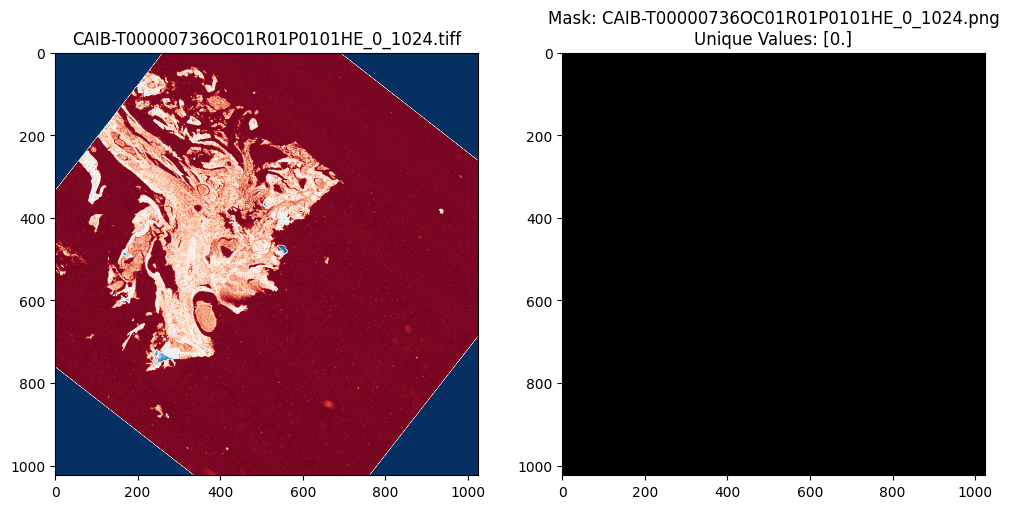

In [13]:
idx = np.random.randint(0,2307)
print(idx)
tdata = train_ds.__getitem__(idx)
unique_mask_values = np.unique(tdata['mask'])
unique_image_values = np.unique(tdata['image'])

fig, axes = plt.subplots(1, 2, figsize=(12, 6))  

#print(tdata['image'])
#print(tdata['mask'])
print('image_shape',tdata['image'].shape)
print('mask_shape',tdata['mask'].shape)



axes[0].imshow(tdata['image'].permute(1,2,0),cmap = 'RdBu_r',vmin=0,vmax=1)
axes[0].set_title(tdata['image_filename'])

axes[1].imshow(tdata['mask'], cmap='gray', vmin=0, vmax=1)

axes[1].set_title(f"Mask: {tdata['mask_filename']}\nUnique Values: {unique_mask_values}")

plt.show()

In [14]:
#Losses
class CombinedLoss(nn.Module):
    def __init__(self, dice_weight=1, bce_weight=1, focal_weight=1):
        super(CombinedLoss, self).__init__()
        self.dice_weight = dice_weight
        self.bce_weight = bce_weight
        self.focal_weight = focal_weight

    def forward(self, outputs, mask):
        # Calculate Dice Loss (imported from SMP)
        dice_loss = smp.losses.DiceLoss(mode='multiclass')(outputs, mask)

        # Calculate BCE Loss
        bce_loss = torch.nn.functional.cross_entropy(outputs, mask)

        # Calculate Focal Loss (imported from SMP)
        focal_loss = smp.losses.FocalLoss(mode='multiclass')(outputs, mask)

        # Combine the three losses
        combined_loss = (
            self.dice_weight * dice_loss +
            self.bce_weight * bce_loss +
            self.focal_weight * focal_loss
        )

        return combined_loss
criterion = CombinedLoss(dice_weight=0.4, bce_weight=0.3, focal_weight=0.3)

In [ ]:
#criterion1 = smp.losses.TverskyLoss(mode='multiclass',classes = 2,log_loss= True,from_logits=True,ignore_index=None,eps = 1e-07)
#crietrion2 = smp.losses.DiceLoss(mode = 'multiclass',classes=2,log_loss= True,from_logits=True,ignore_index=None,eps = 1e-07)
#criterion3 = smp.losses.FocalLoss(mode = 'multiclass',classes =2 ,alpha=None,gamma=2.0,ignore_index=None,reduction= 'mean',normalized=False,reduced_threshold=None)
#criterion4 = smp.losses.JaccardLoss(mode = 'multiclass',classes =2,log_loss = True,from_logits=True,smooth=0.0,eps = 1e-07)
#criterion5 = smp.losses.LovaszLoss(mode = 'multiclass',per_image=True,ignore_index=None,from_logits=True)
#criterion6 = smp.losses.SoftBCEWithLogitsLoss(weight=None,ignore_index=None,reduction='mean',smooth_factor=None,pos_weight=None)
#criterion7 = smp.losses.SoftCrossEntropyLoss(reduction= 'mean',smooth_factor=None,ignore_index=None,dim =1)
#criterion8 = smp.losses.MCCLoss(eps=1e-05)